In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#import for rosenbrock plot:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
# other
from pylab import *

# First and second-order methods for optimization

### Gradient Descent

An intuitive choice for descent direction $d$ is the direction of steepest descent.
Following the direction of steepest descent is guaranteed to lead to improvement provided that 
* the objective function is smooth
* the step size is sufficiently small,
* we are not already at a point where the gradient is zero.

The direction of steepest descent is the direction opposite the gradient $\nabla f$, hence the name gradient
descent. In gradient descent, one typically normalizes the direction of steepest descent

$$
d^{(k)} = -\frac{\nabla f(x^{(k)})}{||\nabla f(x^{(k)})||}= -\frac{g^{(k)}}{||g^{(k)}||}
$$

where we have introduced the notation $g^{(k)}=\nabla f(x^{(k)})$ for simplicity.

#### Rosenbrock function

$$
f(x,y)=b(y−x^2)^2+(a−x)^2
$$

The function has a global minimum at (1,1) and the standard expression takes a=1,b=100


In [11]:
def rosen(x):
    """Generalized n-dimensional version of the Rosenbrock function"""
    return np.sum(100*(x[1:]-x[:-1]**2.0)**2.0 +(1-x[:-1])**2.0,axis=0)

In [12]:
def rosen_der(x):
    """Derivative of generalized Rosen function."""
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

In [13]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

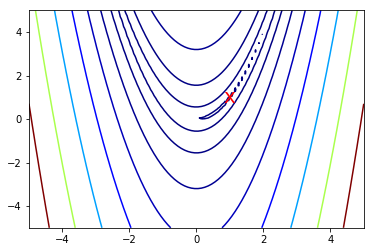

In [14]:
# Note: the global minimum is at (1,1) in a tiny contour island
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

In [15]:
#zooming at the global minimum
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))


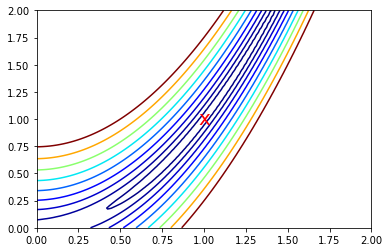

In [16]:
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 1.5, 10)], cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

In [17]:
x0 = np.array([[4,-4.1]]).T
def gradient_descent(x0, cost, gradient, steps=10, α=0.1):
    Tmp = [x0]
    for iteration in range(steps):
        d = -gradient(x0)
        x0 = x0+ α*d/np.linalg.norm(d)
        Tmp.append(x0)
    return Tmp
output = gradient_descent(x0, rosen, rosen_der,  steps=100, α=0.1)
output = np.hstack(output)

In [18]:

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))



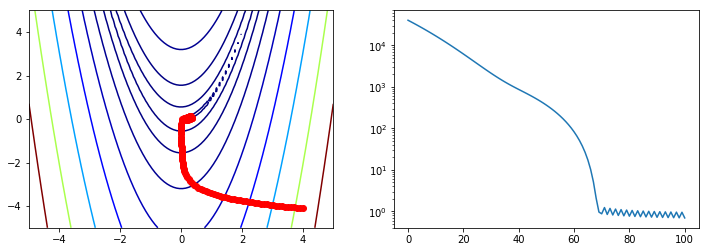

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(output.T[:, 0], output.T[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(output.shape[1]), rosen(output));



### Momentum

Gradient descent will take a long time to traverse a nearly flat surface. 
Allowing momentum to accumulate is one way to speed progress.
We can modify gradient descent to incorporate momentum.

The momentum update equations are:

$$
\begin{aligned}
v^{(k+1)} &= \beta v^{(k)} - \alpha g^{(k)} \\
x^{(k+1)} &= x^{(k)} + v^{(k+1)} 
\end{aligned}
$$

with $\beta, \alpha \in [0,1]$, $\beta$ is called momentum decay and $\alpha$ is the learning rate.

For $\beta= 0$, we recover gradient descent. Intuitively you can think about those equations
as a dynamical system: $x$ is the position,  $v$ is the velocity (momentum) vector and $g^{(k)}$ is the acceleration (force) vector.

To better understand the momentum parameters, let us simplify the scenario by assuming the gradients $ g^{(k)} $ are the same as $d$ throughout the iterations. Since all the gradients are perfectly aligned to the same direction, the momentum algorithm accelerates the advancement along the same direction of $d$ as

$$
\begin{aligned}
v^{(1)} &=  -\alpha d \\
v^{(2)} &= \beta v^{(1)}- \alpha d=-\alpha d(\beta+1) \\
v^{(3)} &= \beta v^{(2)}- \alpha d=-\alpha d(\beta^2+\beta+1) \\
\dots & \dots\\
v^{(inf)} &= -\frac{\alpha d}{1-\beta} \\
\end{aligned}
$$

Thus, if $\beta=0.99$, the final velocity is 100 times faster than that of the corresponding gradient descent where the gradient is $d$.


Hence the issue of momentum is that the steps do not slow down enough at the bottom
of a valley and tend to overshoot the valley floor.

In [20]:
def minimize(θ0, cost, gradient, α=0.1, β=0.0, steps=100, ϵ_x =  1e-8, ϵ_d = 1e-8):
    Tmp = [θ0]
    v = 0;
    for iteration in range(steps):
        g = gradient(θ0)
        if np.linalg.norm(g) < ϵ_d:
            print("Gradient norm below threshold")
            break        
        #momentum
        v = β*v - α*g/np.linalg.norm(g)
        θ1 = θ0 + v
        if np.linalg.norm(θ1-θ0)<ϵ_x:
            print("Step Tolerance below threshold")
            break
        θ0 = θ1
        Tmp.append(θ1)
    return np.array(Tmp)


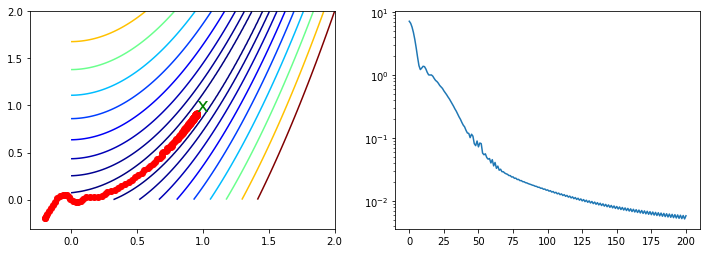

In [21]:
#zooming at the global minimum
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

x0 = np.array([[-0.2,-0.2]]).T
output = minimize(x0, rosen, rosen_der,  steps=200, α=0.01, β=0.8)
output = np.hstack(output)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 2, 10)], cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='green', fontsize=20);
plt.plot(output.T[:, 0], output.T[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(output.shape[1]), rosen(output));

#### Digression on Linear regression

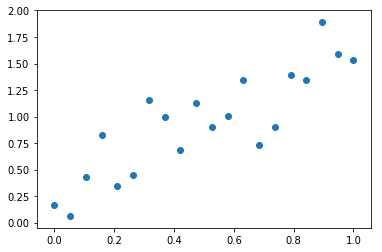

In [221]:
# generate some data
np.random.seed(42)
x = np.linspace(0,1,20)
β = 2
y = x*β + np.random.randn(len(x))/3
plt.scatter(x,y)
X = x.reshape(-1,1) #np.hstack([np.ones((len(x),1)),x.reshape(-1,1)])

In [222]:
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    #

def loss(x,y,θ):
    return (y-x.dot(θ))**2 

def cost(θ):
    return np.sum(loss(X,y,θ))
        
gradcost = grad(cost)
gradcost(np.array([1.24]))

array([-6.93483192])

In [227]:
class GenericLoss_LinearRegression():
    def __init__(self, θ, loss):
        self.θ = θ
        self.loss = loss
        
    def fit(self,X,y,Optimparam):    
        #cost function
        def cost(θ):
            #print(np.sum(self.loss(X,y,θ)))
            return np.sum(self.loss(X,y,θ))
        #automatic diff gradient function
        gradcost = grad(cost)

        #call the optimizer
        θ = minimize(self.θ, cost, gradcost, α=Optimparam['learning_rate'], β=Optimparam['momentum_decay'], steps=Optimparam['steps'], ϵ_x =  Optimparam['ϵ_x'], ϵ_d =  Optimparam['ϵ_d'])
        self.θ = θ[-1]
        plt.plot(θ)
        plt.ylabel("Parameter")
        plt.xlabel("iterations")
        
    def predict(self, X):
        return X.dot(self.θ)

Optimimparam = {
    'steps':250,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001,
    'learning_rate':  0.01,
    'momentum_decay':  0.8,
}


Optimal parameter= [1.75609756]


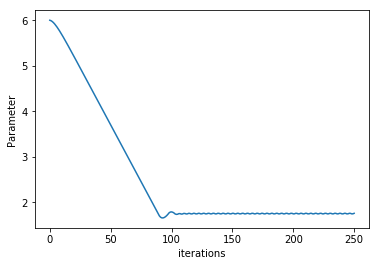

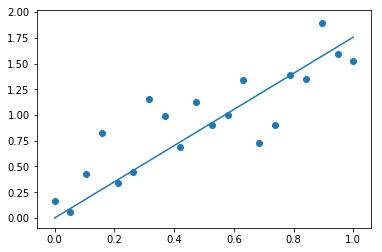

In [228]:
#define my model
GLR = GenericLoss_LinearRegression(np.array([6.0]), loss)
#fitting the data
GLR.fit(X,y,Optimimparam)
print("Optimal parameter=",GLR.θ)
#prediction
ypred =  GLR.predict(X)
plt.figure()
plt.plot(X,ypred)
plt.scatter(X,y)

###  Nesterov momentum
It modifies the momentum algorithm to use the gradient at the projected future position:

$$
\begin{aligned}
v^{(k+1)} &= \beta v^{(k)} - \alpha \nabla f(x^{(k)}+\beta v^{(k)})\\
x^{(k+1)} &= x^{(k)} + v^{(k+1)} 
\end{aligned}
$$

In [231]:
def minimize(θ0, cost, gradient, α=0.1, β=0.0, steps=100, ϵ_x =  1e-8, ϵ_d = 1e-8):
    Tmp = [θ0]
    v = 0;
    for iteration in range(steps):
        g = gradient(θ0+β*v)
        if np.linalg.norm(g) < ϵ_d:
            print("Gradient norm below threshold")
            break
        
        #momentum
        v = β*v - α*g/np.linalg.norm(g)
        θ1 = θ0 + v
        if np.linalg.norm(θ1-θ0)<ϵ_x:
            print("Step Tolerance below threshold")
            break
        θ0 = θ1
        Tmp.append(θ1)
    return np.array(Tmp)

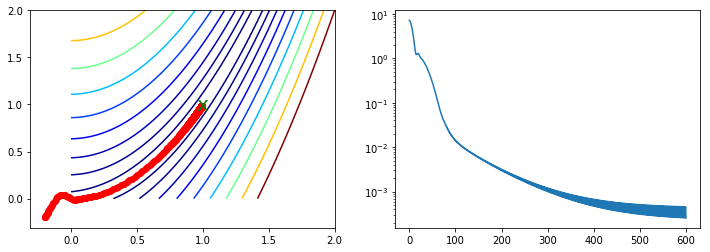

In [246]:
#zooming at the global minimum
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

x0 = np.array([[-0.2,-0.2]]).T
output = minimize(x0, rosen, rosen_der,  steps=600, α=0.003, β=0.9)
output = np.hstack(output)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 2, 10)], cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='green', fontsize=20);
plt.plot(output.T[:, 0], output.T[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(output.shape[1]), rosen(output));

### Adagrad
Momentum and Nesterov momentum update all components of $x$ with the same
learning rate. The adaptive subgradient method, or Adagrad, adapts a
rate for each component of $x$. 

Adagrad dulls the influence of parameters with
consistently high gradients, thereby increasing the influence of parameters with
infrequent updates. 

<div class="alert alert-block alert-success">
<b>Exercise (optional):</b> Implement and run Adagrad and Adam on the rosenbrock function and post the link to your notebook in the Forum for discussions
</div>


###  Large datasets
Standard gradient descent (and variations) computes the gradient of the loss function w.r.t. to the parameters $\theta$ for the entire training dataset.

1.   Using a batch size of $n$, where $n$ is the number of training examples is known as **Batch Gradient Descent (BGD)**. In this case, all of the data is used to calculate the gradient at each step. This results in the *most accurate* estimate of the gradient. 

If the learning rate is not too high, BGD is guaranteed to converge to:
    * the global minimum for convex optimisation surfaces
    * a local minimum for non-convex surfaces (provided that there are no saddle points).
    
 
As we need to calculate the gradients for the whole dataset to perform just one update,  gradient descent can be very slow and is intractable for datasets that don't fit in memory. 

2.   Using a batch size of 1, called **Stochastic Gradient Descent (SGD)**. In this case, only a single data point is used to calculate an estimate of the gradient. Thus, the estimate is very noisy, and we are not guaranteed to find a minimum (local or global). However, SGD still performs very well in practice and allows for online learning. It also turns out that having noisy estimates of the gradient acts as a form of **regularisation** which can prevent over-fitting. 

Finally, because we are performing gradient descent with one example at a time, we need much less memory. Not having enough memory can be a significant issue when using BGD.




3.   Using a batch size of $m < n$ is called **Mini-batch Gradient Descent** and is a compromise between batch and stochastic gradient descent. We use $m$ examples to calculate an estimate of the gradient. Thus, we still have *some* noise in the gradient estimate, we can tune the batch size to make good use of memory, and the variance of the gradient estimate is greatly reduced — which leads to better convergence to local or global minima.

In deep learning, one almost always uses mini-batch gradient descent. However, it is often referred to simply as SGD.


### Stochastic gradient descent
A problem of gradient descent and all the variations we discussed above that can become slow in ML applications when we have a lot of data.

In ML the function we aim to optimize is in general a sum 

In [251]:
def shuffle(X, y):
    Z = np.column_stack((X, y))
    np.random.shuffle(Z)
    return Z[:, :-1], Z[:, -1]

def get_minibatch(X, y, minibatch_size):
    minibatches = []

    X, y =shuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

def momentum(X, y, θ0, minibatch_size, α=0.1, β=0.0, steps=100, ϵ_x =  1e-8, ϵ_d = 1e-8):
    v = 0.0
    Tmp = [θ0]
    minibatches = get_minibatch(X, y, minibatch_size)
    #print(minibatches)
    for iteration in range(steps):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]
        
        #cost function
        def cost(θ):
            return np.sum(loss(X_mini,y_mini,θ))
        #automatic diff gradient function
        gradient = grad(cost)

        #momentum
        g = gradient(θ0)
        v = β*v - α*g
        θ1 = θ0 + v
        
        θ0 = θ1

        
        Tmp.append(θ1)
    return np.array(Tmp)


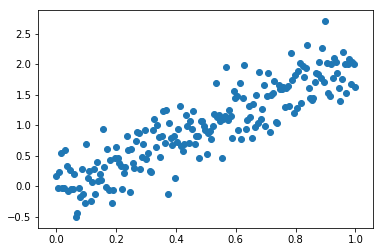

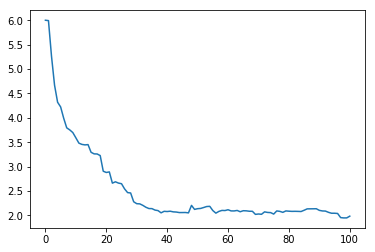

In [267]:
# generate some data
np.random.seed(42)
x = np.linspace(0,1,200)
β = 2
y = x*β + np.random.randn(len(x))/3
plt.scatter(x,y)
X = x.reshape(-1,1) #np.hstack([np.ones((len(x),1)),x.reshape(-1,1)])
plt.figure()
Params=momentum(X, y, np.array([6.0]), 1, α=0.1, β=0.1, steps=100, ϵ_x =  1e-8, ϵ_d = 1e-8)
plt.plot(Params)

In practice, since we usually work with a fixed-size samples and want to make best use of all training data available, we usually use the concept of "epochs". An epoch means "one pass over the training dataset". In particular, what's different from the previous algorithm is that
1. we iterate through the training set and draw a random examples without replacement.
2. we perform epochs, that means we go through the data more than one time.

This is the way that SGD is implemented for ML. 

Note that, by replacing the updating step, we can easily implement stochastic versions of momentum, adagrad, adam. These are at the end the algorithms that, for instance, Keras uses to optimize NNs.


## Second order methods

### Background
Consider thw following two-dimensional function:
$$
 f(x,y)=x^3-2xy-y^6
$$
Let's compute the gradient of $f$.
By definition the gradient is equal to:
$$
\nabla f =\begin{bmatrix}
\frac{\partial}{\partial x} f(x,y)\\
\frac{\partial}{\partial y} f(x,y)
\end{bmatrix}
$$
where
$$
\frac{\partial}{\partial x} f(x,y)= 3x^2-2y
$$
and
$$
\frac{\partial}{\partial y} f(x,y)= -2x-6y^5
$$
 

#### Hessian
The Hessian of $f$ is by definition:
    
$$
H=\nabla^2 f=\begin{bmatrix}
\frac{\partial^2}{\partial x^2} f & \frac{\partial^2}{\partial x \partial y} f\\
\frac{\partial^2}{\partial x \partial y} f & \frac{\partial^2}{\partial y^2} f\\
\end{bmatrix}
$$
where
$$
\frac{\partial^2}{\partial x^2} f(x,y) = 6x, ~~~~\frac{\partial^2}{\partial y^2} f(x,y) = -30 y^4
$$
and
$$
\frac{\partial^2}{\partial x \partial y} f(x,y) = -2
$$

#### Quadratic approximation of function
We can use the Hessian to compute a quadratic approximation of $f$ using a second-order Taylor expansion. 
For instance, let's assume we aim to approximate $ f(x,y)=x^3-2xy-y^6$ around $(x,y)=(1,1)$
The second-order Taylor expansion of $f$ is by definition:

$$
\begin{align}
f(x,y)
&\approx f(1,1) + [x-1,y-1] \begin{bmatrix}
\frac{\partial f}{\partial x} (1,1)\\
\frac{\partial f}{\partial y} (1,1)
\end{bmatrix}  + \frac{1}{2}  [x-1,y-1] \left( \begin{bmatrix}
\frac{\partial^2 f}{\partial x^2} (1,1) & \frac{\partial^2 f}{\partial x \partial y} (1,1)\\
\frac{\partial^2 f}{\partial x \partial y} (1,1) & \frac{\partial^2 f}{\partial y^2} (1,1)\\
\end{bmatrix} \right)  \begin{bmatrix}
x-1\\
y-1
\end{bmatrix}\\
&\approx -2+ [x-1,y-1] \begin{bmatrix}
1\\
-8
\end{bmatrix}  + \frac{1}{2}  [x-1,y-1] \left( \begin{bmatrix}
6 & -2\\
-2 & -30\\
\end{bmatrix} \right)  \begin{bmatrix}
x-1\\
y-1
\end{bmatrix}\\
\end{align}
$$


In [28]:
def f(x,y):
    return x**3-2*x*y-y**6

def T1f(x,y):
    return -2 +np.dot(np.array([[x-1,y-1]]),np.array([[1,-8]]).T)

def T2f(x,y):
    return -2 +np.dot(np.array([[x-1,y-1]]),np.array([[1,-8]]).T)+0.5*np.dot(np.dot(np.array([[x-1,y-1]]),np.array([[6,-2],[-2,-30]]).T),np.array([[x-1,y-1]]).T)
x0=1.0; y0=1.1
print("First order approximation=",f(x0,y0)-T1f(x0,y0))
print("Second order approximation=",f(x0,y0)-T2f(x0,y0))

First order approximation= [[-0.171561]]
Second order approximation= [[-0.021561]]


### Newton's method
Newton's method is based on  a quadratic approximation of $f$ for points near $x_n$.
Assuming that $f$ is twice-differentiable, we can use a quadratic approximation of $f$ for points ‘near’ a fixed point $x$ using a <a href="https://en.wikipedia.org/wiki/Taylor_series">Taylor expansion</a>
$$
\begin{align}
f(x + \Delta x)
&\approx f(x) + \Delta x^T \nabla f(x)  + \frac{1}{2} \Delta x^T \left( \nabla^2 f(x) \right)  \Delta x
\end{align} 
$$
where $\nabla f(x)$ and $\nabla^2 f(x)$ are the gradient and, respectively, Hessian of $f$ at the point $x^{(k)}$. This approximation holds in the limit as $|| \Delta x || \rightarrow 0$. 

To simplify  the notation, we are going to think of our iterative algorithm of producing a sequence of such quadratic approximations $q^{(k)}$. Without loss of generality, we can write $x^{(k+1)} = x^{(k)} + \Delta x$ and re-write the above equation

$$
\begin{align}
q^{(k)}(\Delta x) &= f(x^{(k)}) + \Delta x^T {g}^{(k)} + \frac{1}{2} \Delta x^T  {H}^{(k)}  \Delta x
\end{align} 
$$
where ${g}^{(k)}$ and $ {H}^{(k)}$ represent the gradient and Hessian of $f$ at $x^{(k)}$.

We want to choose $\Delta x$ to minimize this local quadratic approximation of $f$ at $x^{(k)}$. Differentiating with respect to $\Delta x$ above yields:
$$
\begin{align}
\frac{\partial q^{(k)}(\Delta x)}{\partial \Delta x} =g^{(k)} + H^{(k)} \Delta x
\end{align}
$$

Note  that any $\Delta x$ which yields $\frac{\partial q^{(k)}(\Delta x)}{\partial \Delta x} = 0$ is a local extrema of $q^{(k)}(\cdot)$. If we assume that $H^{(k)}$ is [positive definite](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix) (psd) then we know this $\Delta x$ is also a global minimum for $q^{(k)}(\cdot)$. 
Solving for $\Delta x$:

$$
\Delta x = - (H^{(k)})^{-1} g^{(k)}
$$

This suggests $ (H^{(k)})^{-1} g^{(k)}$ as a good direction to move $x^{(k)}$ towards. 


In practice, we set 
$$
x^{(k+1)} = x^{(k)} - \alpha ((H^{(k)})^{-1} g^{(k)})
$$
for a value of $\alpha$ where $f(x^{(k+1)})$ is ‘sufficiently’ smaller than $f(x^{(k)})$.

The above suggests an iterative algorithm:

$$
\begin{align}
 & \mathbf{NewtonRaphson}(f,x^{(0)}): \\
 & \qquad \mbox{For $k=0,1,\ldots$ (until converged)}: \\
 & \qquad \qquad \mbox{Compute $g^{(k)}$ and $H^{(k)}$ for $x^{(k)}$} \\
 & \qquad \qquad d = -(H^{(k)})^{-1} g^{(k)}\\
 & \qquad \qquad \alpha = \min_{\alpha \geq 0} f(x^{(k)} + \alpha d) \\
 & \qquad \qquad x^{(k+1)} \leftarrow x^{(k)} + \alpha d
\end{align} 
$$

<p>The computation of the $\alpha$ step-size can use any number of <a href="https://en.wikipedia.org/wiki/Line_search">line search</a> algorithms. 


In [29]:
def bracket_minimum(f, x=0, s=1e-2, k=2.0): #From the Book, pag.36
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    while True:
        c, yc = b + s, f(b + s)
        if yc > yb:
            return (a, c) if a<c else (c, a)        
        a, ya, b, yb = b, yb, c, yc
        s *= k
        
def line_search(f, x, d, ϵ_x=0.0001, ϵ_d=0.0001):
    term = False
    if np.linalg.norm(d) < ϵ_d:
        print("Gradient norm below threshold")
        term = True
        return x, term
    objective = lambda α : f(x + α*d)
    a, b = bracket_minimum(objective)
    a, b  = golden_section_search(objective, a, b, max_iter = 5, plotting=False)
    α = (a+b)/2
    if np.linalg.norm(x+a*d-x)<ϵ_x:
        print("Step Tolerance below threshold")
        term = True
    return x + α*d, term

from math import sqrt
ϕ = (1 + sqrt(5))/2

def golden_section_search(f, a, b, max_iter, plotting=True): #from the Book pag.41
    a0 =a
    b0=b
    ρ = φ-1
    d = ρ * b + (1 - ρ)*a
    yd = f(d)
    for i in range(max_iter-1):
        c = ρ*a + (1 - ρ)*b
        yc = f(c)
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c   
        if plotting==True:
            plt.figure()
            xx = np.linspace(a0,b0,100)
            plt.plot(xx,f(xx))
            plt.scatter(np.array([a,b]),np.array([a,b])*0)
            plt.scatter(np.array([a,b]),np.array([f(a),f(b)]))

    return (a, b) if a<b else (b, a)

In [30]:
def NewtonRaphson(x0,cost, gradient, hessian, steps=10, ϵ_x=0.0001, ϵ_d=0.0001):
    Tmp = [x0]
    for iteration in range(steps):
        d = gradient(x0)
        H = hessian(x0)
        if H.shape[0]>1:
            d = -np.linalg.inv(H).dot(d) 
        else: #it is a scalar
            d = -d/H 
        #print(β,d)
        x0, term = line_search(cost, x0, d, ϵ_x=ϵ_x, ϵ_d=ϵ_d)
        #print(term)
        if term == True:
            break
        Tmp.append(x0)
    #print(np.array(Tmp))
    return Tmp

In [31]:
def Newton(x0,cost, gradient, hessian, α=0.1, steps=10, ϵ_x=0.0001, ϵ_d=0.0001):
    Tmp = [x0]
    for iteration in range(steps):
        d = gradient(x0)
        H = hessian(x0)
        if H.shape[0]>1:
            d = -np.linalg.inv(H).dot(d) 
        else:
            d = -d/H
        #print(β,d)
        x0 = x0 + α*d
        Tmp.append(x0)
    #print(np.array(Tmp))
    return Tmp

In [32]:
def rosen_hess(x):
    x = x[:,0]
    x = np.atleast_1d(x)
    H = np.diag(-400 * x[:-1], 1) - np.diag(400 * x[:-1], -1)
    diagonal = np.zeros(len(x), dtype=x.dtype)
    diagonal[0] = 1200 * x[0]**2 - 400 * x[1] + 2
    diagonal[-1] = 200
    if len(diagonal[1:-1])>0:
        diagonal[1:-1] = 202 + 1200 * x[1:-1]**2 - 400 * x[2:]
    H = H + np.diag(diagonal)
    return H

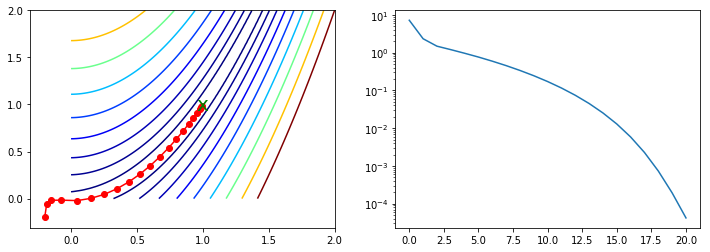

In [33]:
#zooming at the global minimum
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

x0 = np.array([[-0.2,-0.2]]).T
output = Newton(x0,rosen, rosen_der, rosen_hess, steps=20, α=0.6, ϵ_x=0.0001, ϵ_d=0.0001)
output = np.hstack(output)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 2, 10)], cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='green', fontsize=20);
plt.plot(output.T[:, 0], output.T[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(output.shape[1]), rosen(output));

Newton’s method does tend to converge quickly when in a bowl-like region
that is sufficiently close to a local minimum. It has quadratic convergence, meaning
the difference between the minimum and the iterate is approximately squared
with every iteration

### Warnings
The update rule in Newton’s method involves dividing by the second derivative.
The update is undefined if the second derivative is zero, which occurs when the
quadratic approximation is a horizontal line. Instability also occurs when the
second derivative is very close to zero, in which case the next iterate will lie very far
from the current design point, far from where the local quadratic approximation
is valid. Poor local approximations can lead to poor performance with Newton’s
method.


#### Saddle points

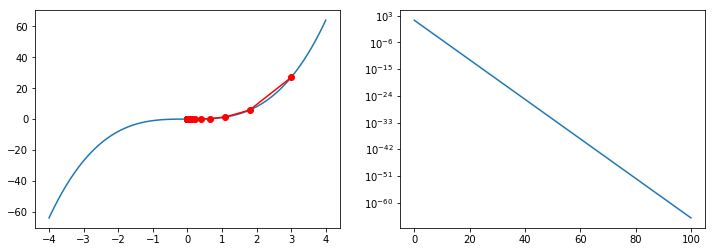

In [34]:
def fun(x):
    return x**3

def fun_der(x):
    return x**2/3

def fun_hess(x):
    return x/6

output = Newton(np.array([3]),fun, fun_der, fun_hess, steps=100, α=0.2, ϵ_x=0.0001, ϵ_d=0.0001)
output = np.hstack(output)
x=np.linspace(-4,4,200)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x,fun(x))
plt.plot(output, fun(output), '-ro')
plt.subplot(122)
plt.semilogy(range(len(output)), fun(output));

For non-convex functions that arise in ML (almost all latent variable models or deep nets), the procedure still works but is only guranteed to converge to a local minimum (see above example). In practice, for non-convex optimization, users need to pay more attention to initialization and other algorithm details.

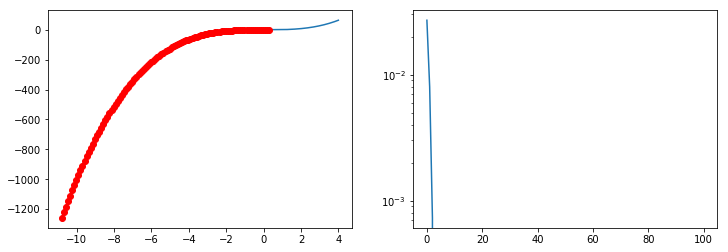

In [35]:
output = minimize(np.array([0.3]),fun, fun_der, α=0.1, β=0.1, steps=100, ϵ_x =  1e-8, ϵ_d = 1e-8)
output = np.hstack(output)
x=np.linspace(-4,4,200)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x,fun(x))
plt.plot(output, fun(output), '-ro')
plt.subplot(122)
plt.semilogy(range(len(output)), fun(output));

By using the momentum term saddle points and local minima become less dangerous for the gradient. Because step sizes towards the global minimum now don’t depend only on the gradient of the loss function at the current point, but also on the velocity that has built up over time. The key insight is that, compared to gradient-descent, adaptive methods (momentum, adagrad, adam) escape saddle points faster, and can converge faster overall to second-order stationary points.

### Hessian
The central issue with NewtonRaphson is that we need to be able to compute the inverse Hessian matrix. Note that for ML applications, the dimensionality of the input to function, that typically corresponds to model parameters. It's not unusual to have hundreds of millions of parameters or in some vision applications even billions of parameters. For these reasons, computing the hessian or its inverse is often impractical. For many functions, the hessian may not even be analytically computable, let along representable.

Because of these reasons, NewtonRaphson is rarely used in practice to optimize functions corresponding to large problems. Luckily, the above algorithm can still work even if $H^{-1}$ doesn't correspond to the exact inverse hessian, but is instead a good approximation.

This leads to Quasi-Newton methods.


###   Quasi-Newton methods.
 We can generalize $\mathbf{NewtonRaphson}$ to take a $\mbox{QuasiUpdate}$ policy which is responsible for producing a sequence of inverse Hessians.

$$
\begin{align}
& \mathbf{QuasiNewton}(f,x^{(0)}, IH^{(0)}, \mbox{QuasiUpdate}): \\
& \qquad \mbox{For $k=0,1,\ldots$ (until converged)}: \\
& \qquad \qquad \mbox{// Compute search direction and step-size } \\
& \qquad \qquad d = -IH^{(k)} g^{(k)} \\
& \qquad \qquad \alpha \leftarrow \min_{\alpha \geq 0} f(x^{(k)} + \alpha d) \\
& \qquad \qquad x^{(k+1)} \leftarrow x^{(k)} + \alpha d \\
& \qquad \qquad \mbox{// Store the input and gradient deltas } \\
& \qquad \qquad g^{(k+1)} \leftarrow \nabla f(x^{(k+1)}) \\
& \qquad \qquad s^{(k+1)} \leftarrow x^{(k+1)} - x^{(k)} \\
& \qquad \qquad y^{(k+1)} \leftarrow g^{(k+1)} - g^{(k)} \\
& \qquad \qquad \mbox{// Update inverse hessian } \\
& \qquad \qquad IH^{(k+1)}  \leftarrow \mbox{QuasiUpdate}(IH^{(k)},\{s^{(k)}\}, \{y^{(k)}\})
\end{align} 
$$

where $𝐼𝐻$ denotes the estimate of the inverse Hessian and $QuasiUpdate$ is the quasi-update strategy.
Many strategies have been proposed for instance the Broyden-Fletcher-Goldfarb-Shannon (BFGS) $QuasiUpdate$

#### Limited-memory BFGS (L-BFGS)
The BFGS quasi-newton approximation has the benefit of not requiring us to be able to analytically compute the Hessian of a function. However, we still must maintain a history of the $s^{(k)}$ and $y^{(k)}$ vectors for each iteration.

For very large problems where space is a concern, the Limited-memory BFGS method (algorithm 6.5 in the Book), or L-BFGS, can be used to approximate BFGS.  L-BFGS stores only the last m values for $s^{(k)}$ and $y^{(k)}$.


In [419]:
#how do we use it
from scipy.optimize import minimize
x0 = np.array([[-1,-1]]).T
res = minimize(rosen, x0, method='BFGS', jac=rosen_der, options={'gtol': 1e-6, 'disp': True})
res

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 40
         Gradient evaluations: 40


      fun: 1.8499214547674284e-16
 hess_inv: array([[0.50825961, 1.01607777],
       [1.01607777, 2.03629519]])
      jac: array([ 2.76270212e-07, -1.26083144e-07])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 31
     njev: 40
   status: 0
  success: True
        x: array([1.00000001, 1.00000002])

In [420]:
res = minimize(rosen, x0, method='L-BFGS-B', jac=rosen_der, options={'gtol': 1e-6, 'disp': True})
res

      fun: 6.521500761717052e-15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.91169805e-06, -1.01852307e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 26
   status: 0
  success: True
        x: array([0.99999994, 0.99999987])